In [75]:
#importer
import torch, sys, os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtik
import numpy as np
from typing import Dict
sys.path.append(os.path.abspath(".."))
from ml_utils import parse_config, activation_decode

### CONSTANTS

In [76]:
DATASET_TRAIN_PATH = 'data/train'
DATASET_TEST_PATH  = 'data/test'
VALID_JSON = {
    "type":"object",
    "properties":
    {
        "nn_config":
        {
            "type":"object",
            "properties":
            {
                "epochs":
                {
                    "type":"integer",
                    "minimum":10
                },
                "batch_size":
                {
                  "type":"integer",
                  "minimum":10
                },
                "act_f":
                {
                    "type":"string",
                    "enum": ["identity", "relu", "sig"]
                },
                "learning_rate":
                {
                    "type":"number",
                    "minimum": 0.0,
                    "maximum":1.0
                },
                "hidden_arr":
                {
                    "type":"array",
                    "items":
                    {
                        "type":"array",
                        "minItems":2,
                        "maxItems":2,
                        "items":
                        {
                            "type":"integer"
                        }
                    }
                }
            },
            "required":["epochs", "batch_size", "act_f", "learning_rate", "hidden_arr"]
        },
        "image":
        {
            "type":"object",
            "properties":
            {
                "w":
                {
                    "type":"integer",
                    "minimum":1
                },
                "h":
                {
                    "type":"integer",
                    "minimum":1
                },
                "path":
                {
                    "type":"string"
                }
            },
            "required":["w", "h", "path"]
        }
    },
    "required":["nn_config","image"]
}

### Prepare data for learning

In [77]:

def prepare_learn_data(config:Dict)->DataLoader:
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.1307), (0.3081))]
    )#(0.1307), (0.3081)
    train_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TRAIN_PATH, train=True, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'], 
        shuffle=True)
    test_loader = DataLoader(
        dataset=datasets.MNIST(root=DATASET_TEST_PATH, train=False, transform=transform, download=True),
        batch_size=config['nn_config']['batch_size'],
        shuffle=False)
    return train_loader, test_loader 

### Vizualization

In [78]:
def vizualization(x:np.array, x_label:str, y:np.array, y_label:str, title:str, x_flag_float:bool=False, y_flag_float:bool=False):
    plt.plot(x, y)
    plt.title(title)
    if x_flag_float:
        plt.ticklabel_format(style='plain', axis='x')
    if y_flag_float:
        plt.gca().yaxis.set_major_formatter(mtik.FormatStrFormatter('%.5f'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Model

In [79]:
from typing import List, Tuple

class NeuralNetwork(nn.Module):
    def __init__(self, hidden_arr:List[Tuple[int, int]], act_f:str) -> None:
        super().__init__()
        self._HIDDEN_ARR = hidden_arr
        self._activation = activation_decode(act_f)
        self._body = self._generate_architecture()
    
    def _generate_architecture(self)->nn.ModuleList:
        hidden = nn.ModuleList()
        for hidden_layer in self._HIDDEN_ARR:
           hidden.append(nn.Linear(hidden_layer[0], hidden_layer[1]))
        return hidden

    def forward(self, x):
        x = x.view(-1, self._HIDDEN_ARR[0][0])  # Flatten the input
        l = len(self._body)-1
        for i, layer in enumerate(self._body):
            x = layer(x)
            if i != l:
                x = self._activation(x)
        return x

### Learning process

In [80]:
def train(device:torch.device, model:NeuralNetwork, config:Dict, train_loader:DataLoader, criterion:nn.CrossEntropyLoss, optimizer:optim.Adam):
    model.train()
    x_epoch = np.array([], dtype=float)
    y_loss = np.array([], dtype=int)
    
    for epoch in range(config['nn_config']['epochs']):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #if batch_idx % 100 == 0:
            #    print(f'Epoch [{epoch+1}/{config['nn_config']['epochs']}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        x_epoch = np.append(x_epoch, epoch)
        y_loss = np.append(y_loss, running_loss)    
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    
    vizualization(x_epoch, 'epochs', y_loss, 'loss', 'loss over epochs', y_flag_float=True)

def test(device: torch.device, model:NeuralNetwork, test_loader:DataLoader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Accuracy on test set: {accuracy:.2f}%')

def learning(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = prepare_learn_data(config)
    model = NeuralNetwork(config['nn_config']['hidden_arr'], config['nn_config']['act_f']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['nn_config']['learning_rate'])
    train(device, model, config, train_loader, criterion, optimizer)
    test(device, model, test_loader)

### Test 1

Epoch 1 finished with avg loss: 0.2505
Epoch 2 finished with avg loss: 0.1035
Epoch 3 finished with avg loss: 0.0745
Epoch 4 finished with avg loss: 0.0557
Epoch 5 finished with avg loss: 0.0464
Epoch 6 finished with avg loss: 0.0373
Epoch 7 finished with avg loss: 0.0314
Epoch 8 finished with avg loss: 0.0312
Epoch 9 finished with avg loss: 0.0228
Epoch 10 finished with avg loss: 0.0215


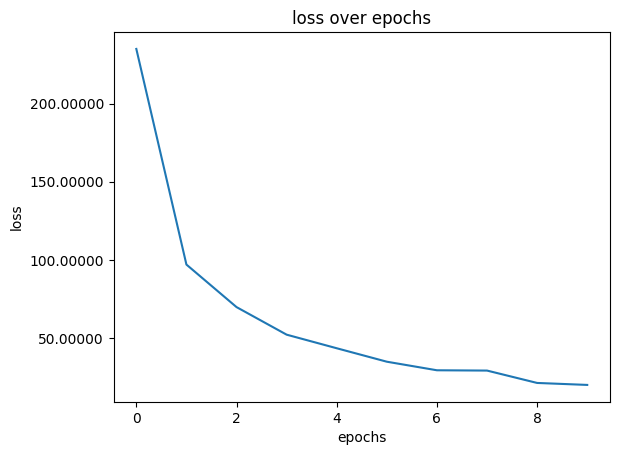

Accuracy on test set: 97.85%


In [81]:
config = parse_config('config/config1.json', VALID_JSON)
learning(config)

### Test 2
Use more deeper structure with decrise inputs cnt

Epoch 1 finished with avg loss: 0.2206
Epoch 2 finished with avg loss: 0.0960
Epoch 3 finished with avg loss: 0.0665
Epoch 4 finished with avg loss: 0.0510
Epoch 5 finished with avg loss: 0.0443
Epoch 6 finished with avg loss: 0.0345
Epoch 7 finished with avg loss: 0.0359
Epoch 8 finished with avg loss: 0.0243
Epoch 9 finished with avg loss: 0.0254
Epoch 10 finished with avg loss: 0.0243


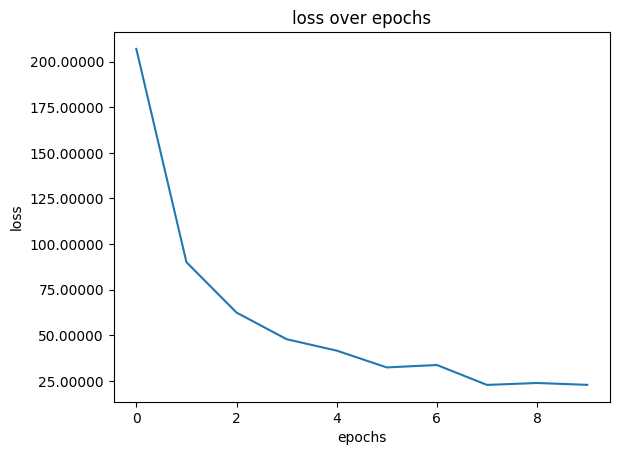

Accuracy on test set: 97.93%


In [82]:
config = parse_config('config/config2.json', VALID_JSON)
learning(config)

### Test 3
Activation function is sig

Epoch 1 finished with avg loss: 0.2422
Epoch 2 finished with avg loss: 0.0988
Epoch 3 finished with avg loss: 0.0694
Epoch 4 finished with avg loss: 0.0519
Epoch 5 finished with avg loss: 0.0410
Epoch 6 finished with avg loss: 0.0348
Epoch 7 finished with avg loss: 0.0302
Epoch 8 finished with avg loss: 0.0255
Epoch 9 finished with avg loss: 0.0223
Epoch 10 finished with avg loss: 0.0221


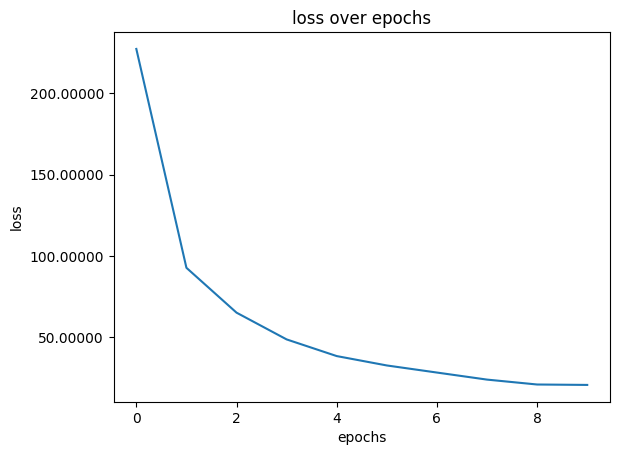

Accuracy on test set: 97.89%


In [83]:
config = parse_config('config/config3.json', VALID_JSON)
learning(config)

### Test 4
Activation function is identity

Epoch 1 finished with avg loss: 0.3798
Epoch 2 finished with avg loss: 0.3212
Epoch 3 finished with avg loss: 0.3140
Epoch 4 finished with avg loss: 0.3025
Epoch 5 finished with avg loss: 0.2970
Epoch 6 finished with avg loss: 0.2909
Epoch 7 finished with avg loss: 0.2878
Epoch 8 finished with avg loss: 0.2860
Epoch 9 finished with avg loss: 0.2822
Epoch 10 finished with avg loss: 0.2789


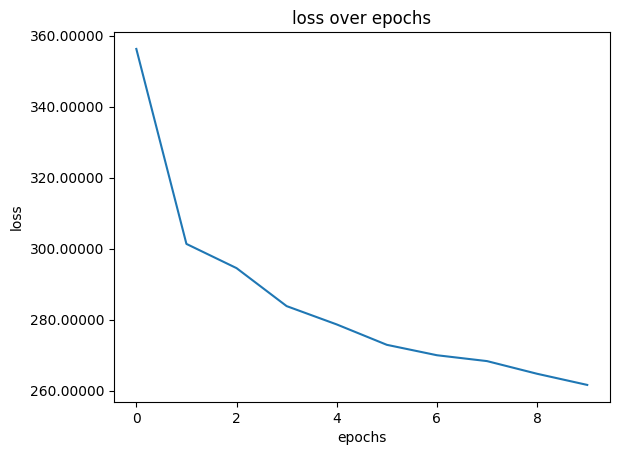

Accuracy on test set: 91.81%


In [84]:
config = parse_config('config/config4.json', VALID_JSON)
learning(config)

### Test 5
Use greater learning rate

Epoch 1 finished with avg loss: 0.2894
Epoch 2 finished with avg loss: 0.2086
Epoch 3 finished with avg loss: 0.1854
Epoch 4 finished with avg loss: 0.1655
Epoch 5 finished with avg loss: 0.1534
Epoch 6 finished with avg loss: 0.1442
Epoch 7 finished with avg loss: 0.1332
Epoch 8 finished with avg loss: 0.1335
Epoch 9 finished with avg loss: 0.1201
Epoch 10 finished with avg loss: 0.1251


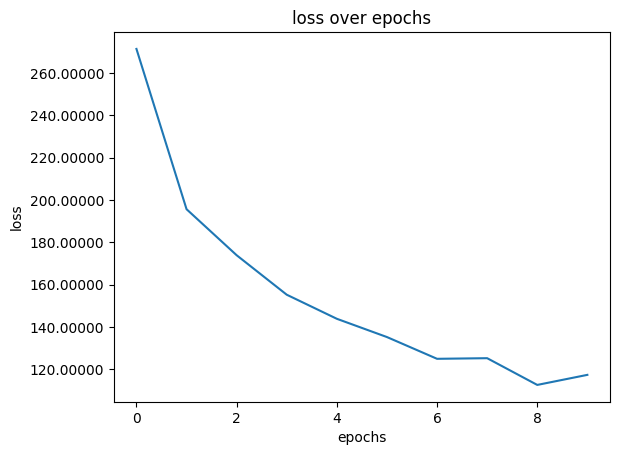

Accuracy on test set: 96.01%


In [85]:
config = parse_config('config/config5.json', VALID_JSON)
learning(config)

### Test 6
Use smaller learning rate

Epoch 1 finished with avg loss: 0.6041
Epoch 2 finished with avg loss: 0.2630
Epoch 3 finished with avg loss: 0.2105
Epoch 4 finished with avg loss: 0.1744
Epoch 5 finished with avg loss: 0.1488
Epoch 6 finished with avg loss: 0.1290
Epoch 7 finished with avg loss: 0.1134
Epoch 8 finished with avg loss: 0.1008
Epoch 9 finished with avg loss: 0.0901
Epoch 10 finished with avg loss: 0.0808


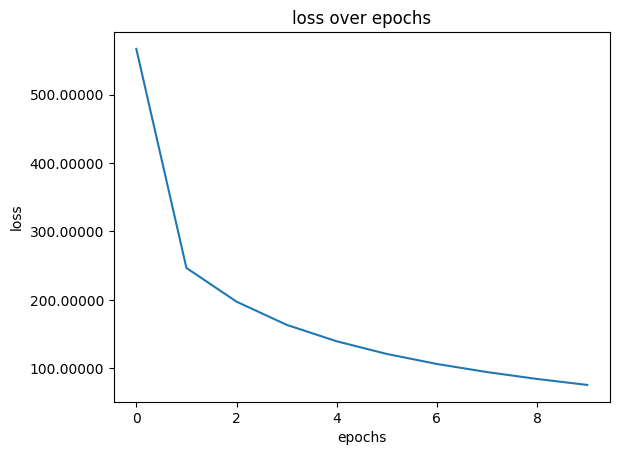

Accuracy on test set: 97.07%


In [86]:
config = parse_config('config/config6.json', VALID_JSON)
learning(config)

### Test 7
Use smaller batches

Epoch 1 finished with avg loss: 0.2247
Epoch 2 finished with avg loss: 0.0993
Epoch 3 finished with avg loss: 0.0713
Epoch 4 finished with avg loss: 0.0581
Epoch 5 finished with avg loss: 0.0475
Epoch 6 finished with avg loss: 0.0403
Epoch 7 finished with avg loss: 0.0340
Epoch 8 finished with avg loss: 0.0320
Epoch 9 finished with avg loss: 0.0288
Epoch 10 finished with avg loss: 0.0251


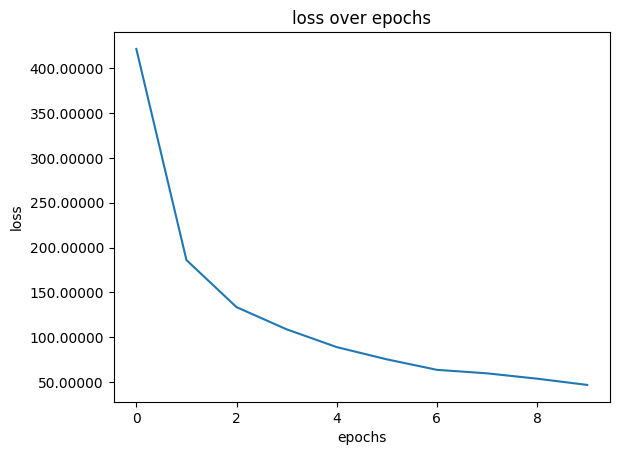

Accuracy on test set: 97.54%


In [87]:
config = parse_config('config/config7.json', VALID_JSON)
learning(config)

### Test 8
Use greater batches

Epoch 1 finished with avg loss: 0.3012
Epoch 2 finished with avg loss: 0.1225
Epoch 3 finished with avg loss: 0.0829
Epoch 4 finished with avg loss: 0.0616
Epoch 5 finished with avg loss: 0.0508
Epoch 6 finished with avg loss: 0.0406
Epoch 7 finished with avg loss: 0.0339
Epoch 8 finished with avg loss: 0.0282
Epoch 9 finished with avg loss: 0.0232
Epoch 10 finished with avg loss: 0.0191


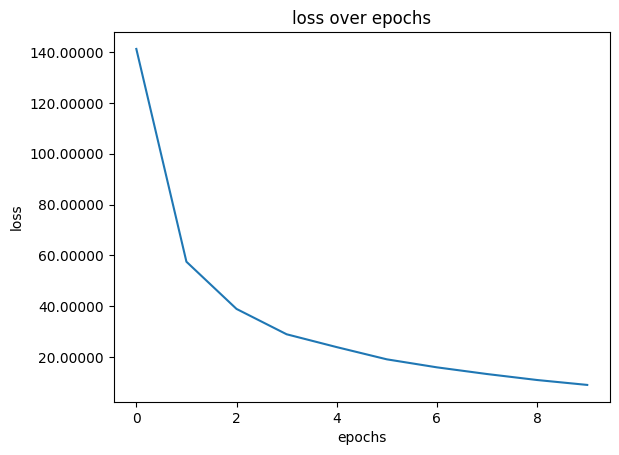

Accuracy on test set: 97.82%


In [88]:
config = parse_config('config/config8.json', VALID_JSON)
learning(config)

### Test 9
Use more epochs

In [89]:
#config = parse_config('config/config9.json', VALID_JSON)
#learning(config)
# need time